# Visualization/Analysis of Local GTFS-RT

In [1]:
import json
import os

from datetime import datetime, timezone

import branca.colormap as cm
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
import seaborn as sns

TZ = pytz.timezone('America/Los_Angeles')

In [2]:
corridor_segments = {
    0: {
        2749,
        2751,
        2752,
        2753,
        2754,
        2755,
        2756,
        2757
    },
    1: {
        12200,
        12201,
        12202,
        12203,
        12204
    },
    2: {
        13532,
        13533,
        13534,
        13535,
        13536
    },
    3: {
        14585,
        14586,
        14587,
        14589,
        14590,
        14591,
        14243
    },
    4: {
        8510,
        8511,
        8512,
        8513,
        8514
    },
    5: {
        13221,
        13220,
        13219,
        13218,
        13217
    },
    6: {
        18045,
        18046,
        18047,
        18048,
        18049
    },
    7: {
        19235,
        19234,
        11333,
        11331,
        11330,
        11329,
        19212
    },
    8: {
        12369,
        12366,
        12365,
        12364,
        12363
    }
}

### Process the Local Summarize_RDS Data

In [3]:
# Location for the local data
path = './transit_vis/data/to_upload'
files = os.listdir(path)

# Join all the data which is saved in different csv for each day
# frames = [pd.read_csv(f"{path}/{filename}", dtype={'trip_short_name': str, 'route_short_name': str}) for filename in files[0:30]]
# all_data = pd.concat(frames)
# all_data.to_csv(f"{path}/../all_data.csv")
# all_data.head()

# If already processed, load the data here and comment out above
all_data = pd.read_csv(f"{path}/../all_data.csv", dtype={'trip_short_name': str, 'route_short_name': str})
all_data.head()

# Rename and style
# all_data['speed_m_s'] = all_data['avg_speed_m_s']
#all_data = all_data[all_data['at_stop'] == True]
sns.set_style('whitegrid')

### Distributions of Key Characteristics/Metrics

15.0
4.0
Corridor 0 performance: 0.26666666666666666


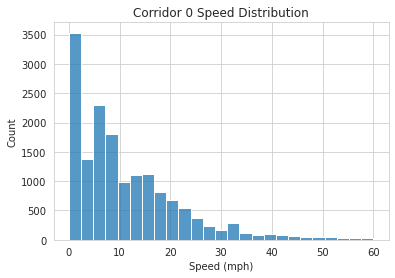

11.0
3.0
Corridor 1 performance: 0.2727272727272727


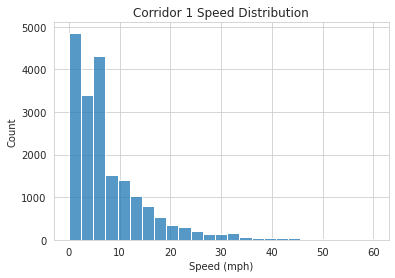

15.0
5.0
Corridor 2 performance: 0.3333333333333333


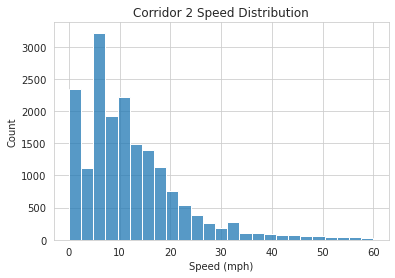

13.0
3.0
Corridor 3 performance: 0.23076923076923078


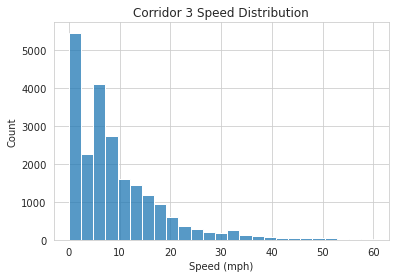

9.0
3.0
Corridor 4 performance: 0.3333333333333333


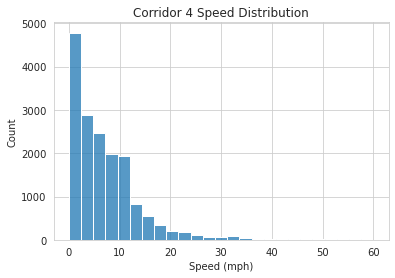

12.0
4.0
Corridor 5 performance: 0.3333333333333333


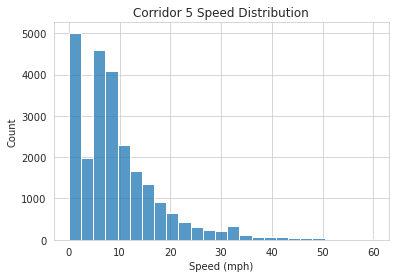

16.0
4.0
Corridor 6 performance: 0.25


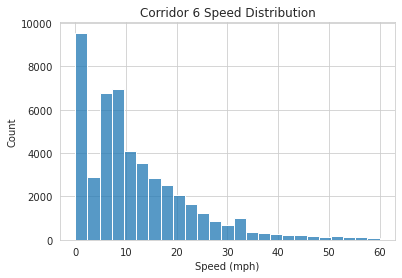

13.0
5.0
Corridor 7 performance: 0.38461538461538464


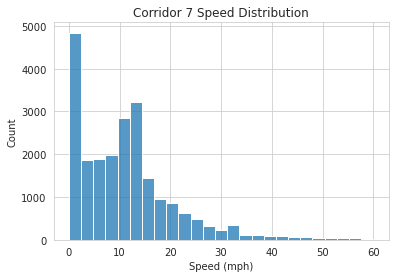

13.0
3.0
Corridor 8 performance: 0.23076923076923078


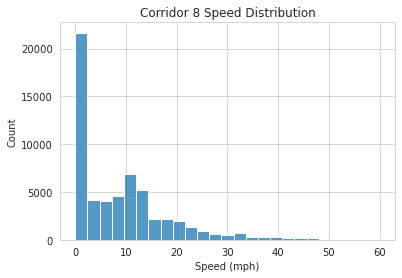

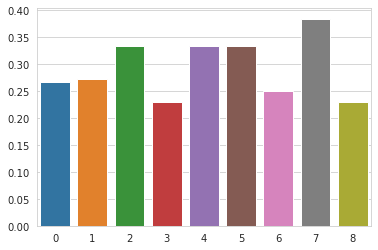

In [37]:
performances = []
labels = []
for corridor in corridor_segments:
    compkeys = corridor_segments[corridor]
    data = all_data.loc[all_data['seg_compkey'].isin(compkeys)]

    ff_speed = np.percentile(data['speed_m_s'], 95)
    med_speed = np.median(data['speed_m_s'])
    print(ff_speed)
    print(med_speed)
    print(f"Corridor {corridor} performance: {med_speed / ff_speed}")
    performances.append(med_speed / ff_speed)
    labels.append(corridor)

    # Regular distributions of speed, deviation, and time changes
    sns.histplot(np.array(data['speed_m_s']) * 2.237, binrange=(0, 60), bins=25).set(xlabel='Speed (mph)', title=f'Corridor {corridor} Speed Distribution')
    plt.show()
sns.barplot(x=labels, y=performances)
plt.show()

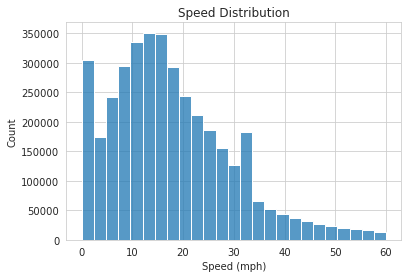

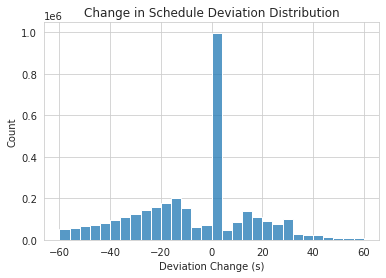

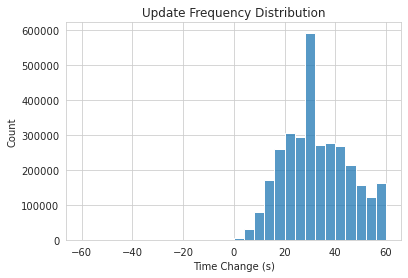

In [13]:
# Regular distributions of speed, deviation, and time changes
speed_data = np.array(all_data['speed_m_s']) * 2.237
sns.histplot(speed_data, binrange=(0, 60), bins=25).set(xlabel='Speed (mph)', title='Speed Distribution')
plt.show()

dev_data = np.array(all_data['deviation_change_s'])
sns.histplot(dev_data, binrange=(-60,60), bins=30).set(xlabel='Deviation Change (s)', title='Change in Schedule Deviation Distribution')
plt.show()

time_data = np.array(all_data['time_diff'])
sns.histplot(time_data, binrange=(-60,60), bins=30).set(xlabel='Time Change (s)', title='Update Frequency Distribution')
plt.show()

### Generate Spatial Heatmaps

In [4]:
# Need to sample to run on normal computer
sampled = all_data.sample(1000000)
# del all_data

In [5]:
# Get daily metric for deviation change
dates = []
times = sampled.locationtime.values
TZ = pytz.timezone('America/Los_Angeles')
for time in times:
    dates.append(datetime.utcfromtimestamp(time).replace(tzinfo=pytz.utc).astimezone(TZ).strftime('%m_%d_%Y'))
sampled['day'] = dates
to_plot_med = sampled.groupby(['day', 'seg_compkey']).sum()[['deviation_change_s']].reset_index()
to_plot_med = sampled.groupby(['seg_compkey']).median()[['deviation_change_s']].reset_index()

# Get overall metric for speed
to_plot_spd = sampled.groupby(['seg_compkey']).median()[['speed_m_s', 'deviation_change_s']]
to_plot_95 = sampled.groupby(['seg_compkey']).quantile(.95)[['speed_m_s']]
to_plot = pd.merge(to_plot_95, to_plot_spd, on='seg_compkey')
#to_plot = pd.merge(to_plot, to_plot_med, on='seg_compkey')
to_plot['performance'] = to_plot['speed_m_s_y'] / to_plot['speed_m_s_x']
to_plot['performance'] = np.nan_to_num(to_plot['performance'])
metric_lookup = to_plot.to_dict(orient='index')

# Keep track of all values for the linear colormapping
speeds = np.array(to_plot['speed_m_s_y'])
deviations = np.array(to_plot['deviation_change_s'])
performances = np.array(to_plot['performance'])

# Write speeds from dict to temp geojson file
with open(f"{path}/../streets_0001buffer.geojson", 'r') as shapefile:
    streets = json.load(shapefile)
for feature in streets['features']:
    compkey = feature['properties']['COMPKEY']
    if compkey in metric_lookup.keys():
        speed = metric_lookup[compkey]['speed_m_s_y']
        dev_change = metric_lookup[compkey]['deviation_change_s']
        performance = metric_lookup[compkey]['performance']
        feature['properties']['MED_SPEED_M_S'] = speed
        feature['properties']['DEVIATION_CHG_S'] = dev_change
        feature['properties']['PERFORMANCE'] = performance
    else:
        feature['properties']['MED_SPEED_M_S'] = 0
        feature['properties']['DEVIATION_CHG_S'] = 0
        feature['properties']['PERFORMANCE'] = 0
with open(f"{path}/../streets_0001buffer_tmp.geojson", 'w+') as new_shapefile:
    json.dump(streets, new_shapefile)

In [16]:
# Initialize the map
f_map = folium.Map(
    location=[47.606209, -122.332069],
    zoom_start=11,
    prefer_canvas=True)

# Add street segments

# linear_cm_spd = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     vmin=np.min(speeds),
#     vmax=np.percentile(speeds, 95))
# folium.GeoJson(
#     name='Seattle Streets Median Speed',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else linear_cm_spd(feature['properties']['MED_SPEED_M_S']),
#         'weight': 2 if feature['properties']['MED_SPEED_M_S'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['MED_SPEED_M_S'],
#         aliases=['Speed (m/s)'])
# ).add_to(f_map)
# linear_cm_spd.add_to(f_map)

# linear_cm_dev = cm.LinearColormap(
#     ['red', 'white', 'blue'],
#     vmin=np.percentile(deviations, 1),
#     vmax=np.percentile(deviations, 99))
# folium.GeoJson(
#     name='Seattle Streets Median Deviation Change',
#     data=f"{path}/../streets_0001buffer_tmp.geojson",
#     style_function=lambda feature: {
#         'color': 'gray' if feature['properties']['DEVIATION_CHG_S'] == 0 \
#             else linear_cm_dev(feature['properties']['DEVIATION_CHG_S']),
#         'weight': 2 if feature['properties']['DEVIATION_CHG_S'] == 0 \
#             else 3},
#     highlight_function=lambda feature: {
#         'fillColor': '#ffaf00', 'color': 'blue', 'weight': 3},
#     tooltip=folium.features.GeoJsonTooltip(
#         fields=['DEVIATION_CHG_S'],
#         aliases=['Deviation Change (s)'])
# ).add_to(f_map)
# linear_cm_dev.add_to(f_map)

linear_cm_per = cm.LinearColormap(
    ['red', 'white', 'blue'],
    #vmin=np.min(performances),
    vmin=np.percentile(performances, 0),
    vmax=np.percentile(performances, 100))
folium.GeoJson(
    name='Seattle Streets Performance',
    data=f"{path}/../streets_0001buffer_tmp.geojson",
    style_function=lambda feature: {
        'color': 'gray' if feature['properties']['PERFORMANCE'] == 0 \
            else linear_cm_per(feature['properties']['PERFORMANCE']),
        'weight': 2 if feature['properties']['PERFORMANCE'] == 0 \
            else 3},
    highlight_function=lambda feature: {
        'fillColor': '#ffaf00', 'color': 'blue', 'weight': 6},
    tooltip=folium.features.GeoJsonTooltip(
        fields=['PERFORMANCE'],
        aliases=['Median Speed / 95th Percentile'])
).add_to(f_map)
linear_cm_per.add_to(f_map)

# Create and add layer for all the sampled coordinate data
# lats = sampled['lat'].tolist()
# lons = sampled['lon'].tolist()
# points = zip(lats, lons)
# points = list(points)
# HeatMap(
#     data=points,
#     name='Points',
#     radius=8,
#     min_opacity=0.2
# ).add_to(f_map)



folium.LayerControl().add_to(f_map)

# Save map and plot in notebook
f_map.save(f"./local_sampled_map.html")
f_map

In [2]:
import json
import pandas as pd

In [4]:
route_dict = {}
d = pd.read_csv('d.csv')

In [5]:
d

LINEARID      FULLNAME RTTYP  MTFCC  length  seg_length  COMPKEY  \
0      11019665258360     1st Ave N     M  S1400    1242         130      844   
1      11019665258360     1st Ave N     M  S1400    1242         130      846   
2      11019665258360     1st Ave N     M  S1400    1242         145      847   
3      11019665258360     1st Ave N     M  S1400    1242         130      854   
4      11019665258360     1st Ave N     M  S1400    1242         130      855   
...               ...           ...   ...    ...     ...         ...      ...   
26878    110854239415  Broadway Ave     M  S1400    1894          85   128785   
26879    110854239415  Broadway Ave     M  S1400    1894          37   128787   
26880    110854239415  Broadway Ave     M  S1400    1894          67   128788   
26881    110854239415  Broadway Ave     M  S1400    1894         129   128789   
26882    110854239415  Broadway Ave     M  S1400    1894         260   128790   

       OBJECTID  CHANGE_NUM  MINOR_CHAN  CURRENT_NE IN_SERVICE  ROUTE_ID  \
0             1         146           5  IN SERVICE          Y    100001   
1             1         146           5  IN SERVICE          Y    100001   
2             1         146           5  IN SERVICE          Y    100001   
3             1         146           5  IN SERVICE          Y    100001   
4             1         146           5  IN SERVICE          Y    100001   
...         ...         ...         ...         ...        ...       ...   
26878       162         146           5  IN SERVICE          Y    102638   
26879       162         146           5  IN SERVICE          Y    102638   
26880       162         146           5  IN SERVICE          Y    102638   
26881       162         146           5  IN SERVICE          Y    102638   
26882       162         146           5  IN SERVICE          Y    102638   

      LOCAL_EXPR  ROUTE_NUM    SHAPE_Leng  
0              L          1  41571.633184  
1              L          1  41571.633184  
2              L          1  41571.633184  
3              L          1  41571.633184  
4              L          1  41571.633184  
...          ...        ...           ...  
26878          L         96  15975.169094  
26879          L         96  15975.169094  
26880          L         96  15975.169094  
26881          L         96  15975.169094  
26882          L         96  15975.169094  

[26883 rows x 16 columns]

In [6]:
route_dict = {}
d = pd.read_csv('d.csv') # .csv of street_route.geojson
d = d[['COMPKEY','ROUTE_NUM','LOCAL_EXPR']]
d['ROUTE_NUM'] = d['ROUTE_NUM'].astype(str)
d['route_id'] = d['ROUTE_NUM'] + d['LOCAL_EXPR']
d = d[['COMPKEY','route_id']].sort_values(by='route_id')
route_ids = pd.unique(d['route_id'])
for routeid in route_ids:
    keys = d[d['route_id']==routeid][['COMPKEY']].values.flatten().tolist()
    route_dict[routeid] = keys
    
with open("route_compkey_dict.json", "w") as outfile:  
    json.dump(route_dict, outfile)